## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import DataProcessor
import srmse
import vae

In [2]:
# Load in the persons PUMS dataset for WA state
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose PUMS and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data = h_df[['WGTP','HINCP','NP','VEH','BLD','ACCESS']].copy()

# Convert numerical variables to categorical bins
pums_data['HINCP'], hincp_bins = pd.qcut(pums_data['HINCP'], q=10, labels=False, retbins=True)

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

# Scale by the household-weights to get true population
# pums_data = pums_data.reindex(pums_data.index.repeat(pums_data['WGTP']))
pums_data = pums_data.drop('WGTP', axis=1)
# pums_data = pums_data.sample(150000)
pums_data

Dataset n=164836 pre-cleaning
Dataset n=140586 post-cleaning


,HINCP,NP,VEH,BLD,ACCESS
0,7.0,2,2.0,2.0,1.0
1,5.0,2,2.0,5.0,1.0
2,9.0,3,3.0,2.0,1.0
3,3.0,2,3.0,1.0,3.0
4,2.0,5,0.0,2.0,1.0
...,...,...,...,...,...
161771,8.0,4,2.0,2.0,1.0
161772,4.0,2,2.0,2.0,1.0
161774,4.0,3,2.0,2.0,1.0
161775,7.0,4,2.0,3.0,1.0


In [4]:
VAR_DIM = pums_data.shape[1]
VAR_NAMES = pums_data.columns

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
pums_encodings_list = []
for x in range(VAR_DIM):
    dummies = pums_data.iloc[:,x]
    pums_encodings_list.append(np.unique(dummies.values))
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]

In [5]:
# Final data frame after encoding OHE
model_data_df = pd.DataFrame()
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Preview data that will be fed into model
model_data_df

,HINCP__0.0,HINCP__1.0,HINCP__2.0,HINCP__3.0,HINCP__4.0,HINCP__5.0,HINCP__6.0,HINCP__7.0,HINCP__8.0,HINCP__9.0,...,BLD__4.0,BLD__5.0,BLD__6.0,BLD__7.0,BLD__8.0,BLD__9.0,BLD__10.0,ACCESS__1.0,ACCESS__2.0,ACCESS__3.0
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161771,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
161772,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161774,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
161775,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Separate into train/test data
model_data = model_data_df.values
train_idx = round(len(model_data)*.7)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

print(f"Training on {train_idx} samples")

Training on 98410 samples


## Set Parameters and Define Model

In [7]:
# Grid Search SRMSE 1
# BATCH_SIZES = [64, 128, 256, 512, 1024]
# EPOCHS = [1000]
# LATENT_DIMS = [2, 3, 4]
# HIDDEN_DIMS = [8, 16, 32, 64]
# KL_WEIGHTS = [.01, .05, .1, 1.0]
# [155.67232656478882, 1.8501038551330566, 0.05296959012880786, 0.02081236519716125, [128, 1000, 2, 32, 0.05]]
# [98.54442024230957, 1.7626943588256836, 0.06421160670330948, 0.020779257538261826, [256, 1000, 4, 32, 0.1]]
# [44.24084186553955, 2.3369486331939697, 0.06478558327639009, 0.02501131310084622, [1024, 1000, 4, 16, 0.1]]

# Hyperparameters
BATCH_SIZE = 1024
EPOCHS = 1000
LATENT_DIM = 4
HIDDEN_DIM = 16
KL_WEIGHT = .05

## Training

In [8]:
val_loss = []
val_epochs = []
class validationCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            val_epochs.append(epoch)
            # Use random sample of 1000 from test data to validate the model
            idx = np.random.randint(test_data.shape[0], size=1000)
            val_data = test_data[idx]
            results = vae_model.predict(val_data)
            loss_cat = vae.get_reconstruction_loss(val_data, results, CAT_LENGTHS)
            val_loss.append(float(loss_cat))

In [9]:
def testModel(test_vae, latent_dim):
    # How many synthetic households to generate
    POP_SIZE = 100000  # Number of hh in WA

    # Generate random normal sample to represent each latent variable, for each row (different hh per row)
    np.random.seed(42)
    inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, latent_dim))

    start_time = time.time()
    # Generate households; each hh has unique latent input
    results = test_vae.decoder.predict([inputs, inputs[:,latent_dim:]])  # Nothing is actually in the second input
    gen_time = time.time() - start_time

    synth_hh_df = pd.DataFrame()
    for i, x in enumerate(results[0]):
        result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
        result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
        synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)
    synth_hh_df.columns = VAR_NAMES
    
    # Get univariate and bivariate srmse for the current model
    srmse_uni = srmse.calculateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))
    srmse_bi = srmse.calculateBivariateSRMSE(synth_hh_df, pums_data.sample(POP_SIZE, random_state=42))

    return gen_time, srmse_uni, srmse_bi

In [10]:
# HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)

# # Use grid search to train model and get results for many different hyperparameters
# grid_search_results = []
# for bs in BATCH_SIZES:
#     for e in EPOCHS:
#         for ld in LATENT_DIMS:
#             for hd in HIDDEN_DIMS:
#                 for klw in KL_WEIGHTS:
#                     print(f"[{bs}, {e}, {ld}, {hd}, {klw}]")
#                     start_time = time.time()
#                     vae = VAE.VAE(MANIFEST_DIM, hd, ld, CAT_LENGTHS, HH_IDX, klw)
#                     vae.compile(optimizer=keras.optimizers.Adam())
#                     history = vae.fit(train_data, epochs=e, batch_size=bs, callbacks=[validationCallback()], verbose=0)
#                     train_time = (time.time()-start_time)
#                     gen_time, srmse_uni, srmse_bi = testModel(test_vae=vae, latent_dim=ld)
#                     results = [train_time, gen_time, srmse_uni, srmse_bi, [bs,e,ld,hd,klw]]
#                     grid_search_results.append(results)

# # Find the best results for each metric in the grid search
# min_srmse_uni_idx = 0
# min_srmse_uni_value = 999999999
# min_srmse_bi_idx = 0
# min_srmse_bi_value = 999999999
# min_eff_idx = 0
# min_eff_value = 999999999
# for i, result in enumerate(grid_search_results):
#     tot_time = result[0]+result[1]
#     time_eff = (result[2]+result[3] / 2) * tot_time
#     if result[2] < min_srmse_uni_value:
#         min_srmse_uni_idx = i
#         min_srmse_uni_value = result[2]
#     if result[3] < min_srmse_bi_value:
#         min_srmse_bi_idx = i
#         min_srmse_bi_value = result[3]
#     if time_eff < min_eff_value:
#         min_eff_idx = i
#         min_eff_value = time_eff

# # Display the results
# print(grid_search_results[min_srmse_uni_idx])
# print(grid_search_results[min_srmse_bi_idx])
# print(grid_search_results[min_eff_idx])

In [11]:
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
HH_IDX

5

In [12]:
# Train the model using single set of hyperparameters
HH_IDX = len(CAT_LENGTHS)  # Number of household variables (used in CVAE)
start_time = time.time()

vae_model = vae.VAE(MANIFEST_DIM, HIDDEN_DIM, LATENT_DIM, CAT_LENGTHS, HH_IDX, KL_WEIGHT)
vae_model.compile(optimizer=keras.optimizers.Adam())
history = vae_model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[validationCallback()])

train_time = (time.time()-start_time)
print(train_time)

Metal device set to: Apple M1
Epoch 1/1000


2021-12-20 11:52:28.606699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-20 11:52:28.606776: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-20 11:52:28.733223: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-20 11:52:29.027687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - ETA: 0s - tot_loss: 8.8305 - rec_loss: 8.7081 - kl_loss: 0.1224

2021-12-20 11:52:31.229937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


97/97 [==============================] - 3s 24ms/step - tot_loss: 8.8305 - rec_loss: 8.7081 - kl_loss: 0.1224
Epoch 2/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 6.6695 - rec_loss: 6.4670 - kl_loss: 0.2025
Epoch 3/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 5.9527 - rec_loss: 5.7367 - kl_loss: 0.2161
Epoch 4/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 5.4794 - rec_loss: 5.2507 - kl_loss: 0.2288
Epoch 5/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 4.9639 - rec_loss: 4.6780 - kl_loss: 0.2860
Epoch 6/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 4.6473 - rec_loss: 4.3190 - kl_loss: 0.3283
Epoch 7/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 4.4684 - rec_loss: 4.1229 - kl_loss: 0.3455
Epoch 8/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 4.3338 - rec_loss: 3.9779 - kl_loss: 0.3559
Epoch 9/1000
97/97 [=========

97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3911 - rec_loss: 0.9032 - kl_loss: 0.4879
Epoch 68/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3807 - rec_loss: 0.8924 - kl_loss: 0.4882
Epoch 69/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3744 - rec_loss: 0.8866 - kl_loss: 0.4879
Epoch 70/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3636 - rec_loss: 0.8760 - kl_loss: 0.4877
Epoch 71/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 1.3588 - rec_loss: 0.8716 - kl_loss: 0.4872
Epoch 72/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3474 - rec_loss: 0.8577 - kl_loss: 0.4897
Epoch 73/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3387 - rec_loss: 0.8496 - kl_loss: 0.4892
Epoch 74/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.3342 - rec_loss: 0.8445 - kl_loss: 0.4897
Epoch 75/1000
97/97 [=

97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0565 - rec_loss: 0.5571 - kl_loss: 0.4994
Epoch 133/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0518 - rec_loss: 0.5527 - kl_loss: 0.4991
Epoch 134/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0495 - rec_loss: 0.5497 - kl_loss: 0.4997
Epoch 135/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0468 - rec_loss: 0.5476 - kl_loss: 0.4991
Epoch 136/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0449 - rec_loss: 0.5442 - kl_loss: 0.5007
Epoch 137/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0412 - rec_loss: 0.5409 - kl_loss: 0.5004
Epoch 138/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0380 - rec_loss: 0.5377 - kl_loss: 0.5003
Epoch 139/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 1.0375 - rec_loss: 0.5373 - kl_loss: 0.5001
Epoch 140/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8977 - rec_loss: 0.3930 - kl_loss: 0.5047
Epoch 198/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8965 - rec_loss: 0.3897 - kl_loss: 0.5069
Epoch 199/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8951 - rec_loss: 0.3888 - kl_loss: 0.5063
Epoch 200/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8939 - rec_loss: 0.3869 - kl_loss: 0.5070
Epoch 201/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.8929 - rec_loss: 0.3857 - kl_loss: 0.5072
Epoch 202/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8879 - rec_loss: 0.3816 - kl_loss: 0.5063
Epoch 203/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8867 - rec_loss: 0.3798 - kl_loss: 0.5069
Epoch 204/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.8856 - rec_loss: 0.3785 - kl_loss: 0.5071
Epoch 205/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7897 - rec_loss: 0.2827 - kl_loss: 0.5070
Epoch 263/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7900 - rec_loss: 0.2809 - kl_loss: 0.5091
Epoch 264/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7880 - rec_loss: 0.2791 - kl_loss: 0.5089
Epoch 265/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7838 - rec_loss: 0.2765 - kl_loss: 0.5073
Epoch 266/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7803 - rec_loss: 0.2734 - kl_loss: 0.5069
Epoch 267/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7825 - rec_loss: 0.2742 - kl_loss: 0.5083
Epoch 268/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7807 - rec_loss: 0.2726 - kl_loss: 0.5082
Epoch 269/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.7772 - rec_loss: 0.2698 - kl_loss: 0.5073
Epoch 270/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7098 - rec_loss: 0.2021 - kl_loss: 0.5077
Epoch 328/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7096 - rec_loss: 0.2026 - kl_loss: 0.5070
Epoch 329/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7120 - rec_loss: 0.2059 - kl_loss: 0.5062
Epoch 330/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7085 - rec_loss: 0.2014 - kl_loss: 0.5071
Epoch 331/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.7064 - rec_loss: 0.2003 - kl_loss: 0.5061
Epoch 332/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7038 - rec_loss: 0.1977 - kl_loss: 0.5061
Epoch 333/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7037 - rec_loss: 0.1986 - kl_loss: 0.5051
Epoch 334/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.7048 - rec_loss: 0.1977 - kl_loss: 0.5071
Epoch 335/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6627 - rec_loss: 0.1621 - kl_loss: 0.5006
Epoch 393/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6635 - rec_loss: 0.1610 - kl_loss: 0.5025
Epoch 394/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6627 - rec_loss: 0.1608 - kl_loss: 0.5019
Epoch 395/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6603 - rec_loss: 0.1599 - kl_loss: 0.5003
Epoch 396/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6625 - rec_loss: 0.1603 - kl_loss: 0.5021
Epoch 397/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6634 - rec_loss: 0.1592 - kl_loss: 0.5041
Epoch 398/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6612 - rec_loss: 0.1583 - kl_loss: 0.5029
Epoch 399/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6633 - rec_loss: 0.1588 - kl_loss: 0.5045
Epoch 400/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6388 - rec_loss: 0.1389 - kl_loss: 0.4998
Epoch 458/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6363 - rec_loss: 0.1369 - kl_loss: 0.4994
Epoch 459/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6378 - rec_loss: 0.1363 - kl_loss: 0.5014
Epoch 460/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6361 - rec_loss: 0.1363 - kl_loss: 0.4998
Epoch 461/1000
97/97 [==============================] - 2s 22ms/step - tot_loss: 0.6367 - rec_loss: 0.1364 - kl_loss: 0.5004
Epoch 462/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6341 - rec_loss: 0.1345 - kl_loss: 0.4996
Epoch 463/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6335 - rec_loss: 0.1351 - kl_loss: 0.4984
Epoch 464/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6351 - rec_loss: 0.1347 - kl_loss: 0.5004
Epoch 465/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6201 - rec_loss: 0.1224 - kl_loss: 0.4977
Epoch 523/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6175 - rec_loss: 0.1215 - kl_loss: 0.4960
Epoch 524/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6195 - rec_loss: 0.1223 - kl_loss: 0.4971
Epoch 525/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6191 - rec_loss: 0.1218 - kl_loss: 0.4973
Epoch 526/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6170 - rec_loss: 0.1199 - kl_loss: 0.4970
Epoch 527/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6183 - rec_loss: 0.1213 - kl_loss: 0.4970
Epoch 528/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6180 - rec_loss: 0.1212 - kl_loss: 0.4968
Epoch 529/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6180 - rec_loss: 0.1216 - kl_loss: 0.4965
Epoch 530/1000


97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6070 - rec_loss: 0.1115 - kl_loss: 0.4955
Epoch 588/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6068 - rec_loss: 0.1108 - kl_loss: 0.4960
Epoch 589/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6069 - rec_loss: 0.1122 - kl_loss: 0.4947
Epoch 590/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6057 - rec_loss: 0.1110 - kl_loss: 0.4947
Epoch 591/1000
97/97 [==============================] - 2s 22ms/step - tot_loss: 0.6071 - rec_loss: 0.1115 - kl_loss: 0.4956
Epoch 592/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6059 - rec_loss: 0.1112 - kl_loss: 0.4947
Epoch 593/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.6058 - rec_loss: 0.1109 - kl_loss: 0.4949
Epoch 594/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.6061 - rec_loss: 0.1105 - kl_loss: 0.4956
Epoch 595/1000


97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5952 - rec_loss: 0.1022 - kl_loss: 0.4930
Epoch 653/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5955 - rec_loss: 0.1037 - kl_loss: 0.4918
Epoch 654/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5984 - rec_loss: 0.1046 - kl_loss: 0.4938
Epoch 655/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5962 - rec_loss: 0.1032 - kl_loss: 0.4930
Epoch 656/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5952 - rec_loss: 0.1018 - kl_loss: 0.4935
Epoch 657/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5942 - rec_loss: 0.1018 - kl_loss: 0.4924
Epoch 658/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5943 - rec_loss: 0.1025 - kl_loss: 0.4918
Epoch 659/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5956 - rec_loss: 0.1020 - kl_loss: 0.4936
Epoch 660/1000


97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5878 - rec_loss: 0.0975 - kl_loss: 0.4903
Epoch 718/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5891 - rec_loss: 0.0967 - kl_loss: 0.4924
Epoch 719/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5862 - rec_loss: 0.0961 - kl_loss: 0.4901
Epoch 720/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5876 - rec_loss: 0.0969 - kl_loss: 0.4907
Epoch 721/1000
97/97 [==============================] - 2s 22ms/step - tot_loss: 0.5857 - rec_loss: 0.0963 - kl_loss: 0.4893
Epoch 722/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5857 - rec_loss: 0.0959 - kl_loss: 0.4897
Epoch 723/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5850 - rec_loss: 0.0949 - kl_loss: 0.4901
Epoch 724/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5862 - rec_loss: 0.0968 - kl_loss: 0.4895
Epoch 725/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5779 - rec_loss: 0.0909 - kl_loss: 0.4870
Epoch 783/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5788 - rec_loss: 0.0910 - kl_loss: 0.4878
Epoch 784/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5786 - rec_loss: 0.0905 - kl_loss: 0.4881
Epoch 785/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5801 - rec_loss: 0.0917 - kl_loss: 0.4884
Epoch 786/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5794 - rec_loss: 0.0914 - kl_loss: 0.4880
Epoch 787/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5790 - rec_loss: 0.0913 - kl_loss: 0.4877
Epoch 788/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5787 - rec_loss: 0.0907 - kl_loss: 0.4879
Epoch 789/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5781 - rec_loss: 0.0908 - kl_loss: 0.4873
Epoch 790/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5745 - rec_loss: 0.0889 - kl_loss: 0.4856
Epoch 848/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5737 - rec_loss: 0.0872 - kl_loss: 0.4865
Epoch 849/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5738 - rec_loss: 0.0868 - kl_loss: 0.4870
Epoch 850/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5735 - rec_loss: 0.0864 - kl_loss: 0.4870
Epoch 851/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5734 - rec_loss: 0.0875 - kl_loss: 0.4859
Epoch 852/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5778 - rec_loss: 0.0871 - kl_loss: 0.4907
Epoch 853/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5730 - rec_loss: 0.0871 - kl_loss: 0.4859
Epoch 854/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5737 - rec_loss: 0.0865 - kl_loss: 0.4872
Epoch 855/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5697 - rec_loss: 0.0850 - kl_loss: 0.4847
Epoch 913/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5694 - rec_loss: 0.0837 - kl_loss: 0.4857
Epoch 914/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5671 - rec_loss: 0.0840 - kl_loss: 0.4831
Epoch 915/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5667 - rec_loss: 0.0828 - kl_loss: 0.4839
Epoch 916/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5674 - rec_loss: 0.0839 - kl_loss: 0.4835
Epoch 917/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5653 - rec_loss: 0.0823 - kl_loss: 0.4830
Epoch 918/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5671 - rec_loss: 0.0836 - kl_loss: 0.4835
Epoch 919/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5681 - rec_loss: 0.0838 - kl_loss: 0.4843
Epoch 920/1000


97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5629 - rec_loss: 0.0813 - kl_loss: 0.4816
Epoch 978/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5614 - rec_loss: 0.0809 - kl_loss: 0.4805
Epoch 979/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5643 - rec_loss: 0.0810 - kl_loss: 0.4833
Epoch 980/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5612 - rec_loss: 0.0796 - kl_loss: 0.4816
Epoch 981/1000
97/97 [==============================] - 2s 21ms/step - tot_loss: 0.5611 - rec_loss: 0.0808 - kl_loss: 0.4803
Epoch 982/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5615 - rec_loss: 0.0796 - kl_loss: 0.4819
Epoch 983/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5626 - rec_loss: 0.0800 - kl_loss: 0.4826
Epoch 984/1000
97/97 [==============================] - 2s 20ms/step - tot_loss: 0.5643 - rec_loss: 0.0815 - kl_loss: 0.4828
Epoch 985/1000


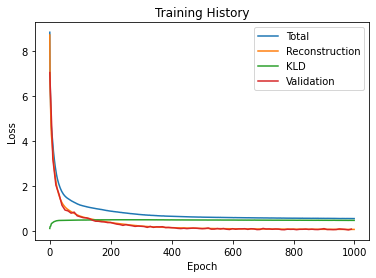

In [13]:
# Plot model loss/training progress
plt.plot(history.history['tot_loss'])
plt.plot(history.history['rec_loss'])
plt.plot(history.history['kl_loss'])
plt.plot(val_epochs, val_loss)
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Total","Reconstruction","KLD","Validation"], loc="upper right")
plt.show()

## Testing

2021-12-20 12:25:21.930990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


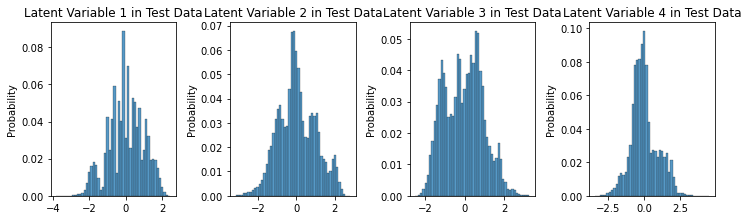

In [14]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae_model.encoder.predict(test_data[:,:MANIFEST_DIM])

# Show distributions of the resulting variables
fig, axes = plt.subplots(nrows=1, ncols=LATENT_DIM, figsize=(10,3))
fig.tight_layout(w_pad=2, h_pad=10)

for i in range(LATENT_DIM):
    sns.histplot(z[:,i], ax=axes[i], bins=50, stat="probability")
    axes[i].set_title(f"Latent Variable {i+1} in Test Data")

In [15]:
# Draw predictions from test data
results = vae_model.predict(test_data)
loss_cat = vae.get_reconstruction_loss(test_data, results, CAT_LENGTHS)
print(f"Categorical Variable Loss: {loss_cat}")

2021-12-20 12:25:23.842454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Categorical Variable Loss: 0.0725640058517456


In [16]:
# Convert the testing data from ohe to values
test_data_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_data_df = pd.concat([test_data_df, result_df], axis=1)
test_data_df.columns = VAR_NAMES

# Convert the test results from logits to values
test_results_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    test_results_df = pd.concat([test_results_df, result_df], axis=1)
test_results_df.columns = VAR_NAMES

## Generating Synthetic Population

In [17]:
# How many synthetic households to generate
POP_SIZE = 100000

# Generate random normal sample to represent each latent variable, for each row (different hh per row)
inputs = np.random.normal(loc=0, scale=1, size=(POP_SIZE, LATENT_DIM))

start_time = time.time()

# Generate households; each hh has unique latent input
results = vae_model.decoder.predict([inputs, inputs[:,LATENT_DIM:]])  # Nothing is actually in the second input

print(f"--- {time.time() - start_time} seconds ---")

2021-12-20 12:25:31.337297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


--- 6.4759910106658936 seconds ---


In [18]:
# Save raw output values to be conditional inputs for the person CVAE
synth_hh_ohe_df = pd.DataFrame()
synth_hh_df = pd.DataFrame()
for i, x in enumerate(results[0]):
    result = np.apply_along_axis(DataProcessor.logit_to_ohe, 1, x)  # Most variables in PUMS are indexed from 1
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_ohe_df = pd.concat([synth_hh_ohe_df, result_df], axis=1)
    
    result = np.apply_along_axis(DataProcessor.logit_to_val, 1, x, pums_encodings_list[i])
    result_df = pd.DataFrame(result).add_prefix(f"{VAR_NAMES[i]}_")
    synth_hh_df = pd.concat([synth_hh_df, result_df], axis=1)

synth_hh_df.columns = VAR_NAMES

synth_hh_df.to_csv('data/synthetic_populations/wa_households.csv', index=False)
synth_hh_ohe_df.to_csv('data/synthetic_populations/wa_households_raw.csv', index=False)

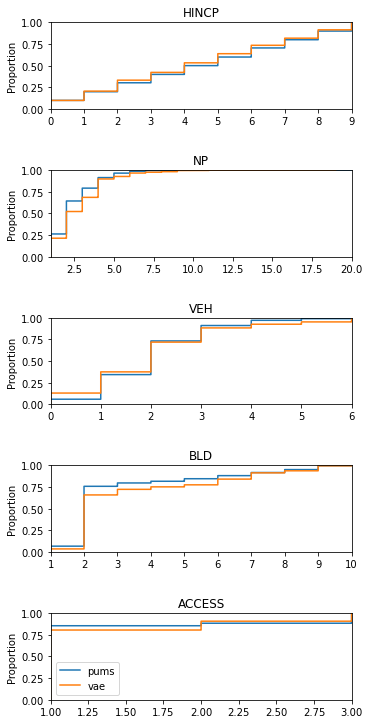

In [19]:
# Generate Distributions of All HH variables
fig, axes = plt.subplots(nrows=len(VAR_NAMES), ncols=1, figsize=(5,10))
fig.tight_layout(h_pad=4)

for i, var in enumerate(VAR_NAMES):
    sns.ecdfplot(data=pums_data, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    sns.ecdfplot(data=synth_hh_df, x=var, ax=axes[i]).set(xlim=(min(pums_data[var]),max(pums_data[var])))
    axes[i].set_title(var)
    axes[i].set_xlabel(None)
    plt.legend(labels=['pums','vae'])

In [20]:
testModel(test_vae=vae_model, latent_dim=LATENT_DIM)
# gen_time, srmse_uni, srmse_bi

Univariate (marginal) SRMSE: 0.2970742924455093, Total Bins: 48
Bivariate (joint) SRMSE: 0.9541625445017217, Total Bins: 861


(4.874605178833008, 0.2970742924455093, 0.9541625445017217)